# Fraud Detection

## Executive Summary
This project develops a predictive model to detect fraudulent transactions for a financial company.
The dataset contains over 6 million transactions with various features such as transaction type, amount, and account balances.

The goal:
- Build a model to detect fraud with high recall (catch as many frauds as possible)
- Identify key factors contributing to fraud
- Provide actionable business recommendations for prevention

**Key Results:**
- Random Forest model achieved high recall and ROC-AUC
- Top fraud indicators: large transaction amounts, unusual balance changes, and specific transaction types (TRANSFER, CASH_OUT)
- Recommendations include real-time scoring, two-factor authentication, and continuous model retraining


In [1]:
# ================================
# IMPORT LIBRARIES
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')


## Step 1 – Load and Explore Data
We start by loading the dataset `Fraud.csv` and checking its structure.

In [2]:

df = pd.read_csv("Fraud.csv")
print("Shape before cleaning:", df.shape)

df = df.dropna()
print("Shape after dropna:", df.shape)

df.head()


Shape before cleaning: (6362620, 11)
Shape after dropna: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Step 2 – Data Overview
- Dataset has 10 columns and ~6.3 million rows.
- Target variable: `isFraud` (1 = fraud, 0 = normal)
- Class distribution is highly imbalanced — fraud cases < 0.2%.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04

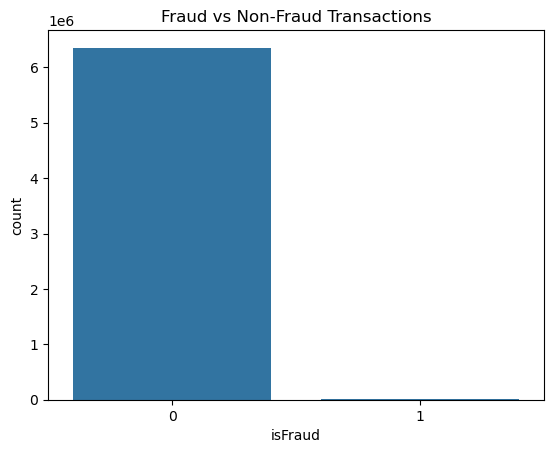

In [3]:

print(df.info())
print(df.describe())

# Class distribution
fraud_percent = df['isFraud'].value_counts(normalize=True) * 100
print("Fraud percentage:\n", fraud_percent)

# Plot fraud distribution
sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()


## Step 3 – Data Cleaning
We check for:
- Missing values
- Outliers in `amount` column
- Multi-collinearity using VIF


Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


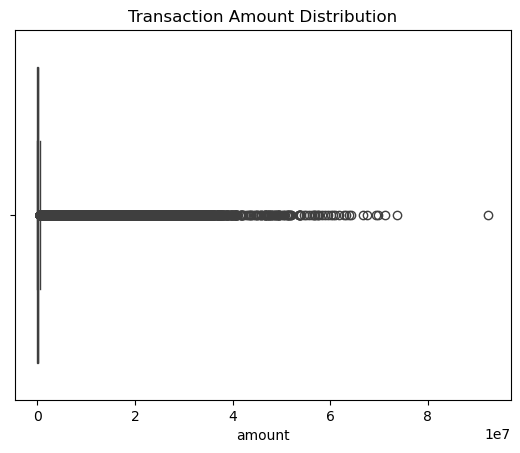

          feature         VIF
0            step    1.188495
1          amount    4.011315
2   oldbalanceOrg  465.122355
3  newbalanceOrig  466.903890
4  oldbalanceDest   71.765327
5  newbalanceDest   83.231611


In [4]:
# ================================
# DATA CLEANING
# ================================
# Missing values
print("Missing values:\n", df.isnull().sum())

# Outlier visualization
sns.boxplot(x=df['amount'])
plt.title("Transaction Amount Distribution")
plt.show()

# Multi-collinearity check
X_temp = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
vif_data = pd.DataFrame()
vif_data['feature'] = X_temp.columns
vif_data['VIF'] = [variance_inflation_factor(X_temp.values, i) for i in range(X_temp.shape[1])]
print(vif_data)


## Step 4 – Feature Selection & Encoding
- Remove ID columns `nameOrig` and `nameDest`
- One-hot encode `type` column
- Drop `isFlaggedFraud` to prevent model leakage

In [5]:
df_model = df.drop(['nameOrig', 'nameDest'], axis=1)
df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)
df_model.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,0,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,False,False,True,False


## Step 5 – Train-Test Split & SMOTE
We split the data into training (70%) and test (30%) sets and use SMOTE to balance classes.

In [6]:
X = df_model.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df_model['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_res.value_counts())


Before SMOTE:
 isFraud
0    4448085
1       5749
Name: count, dtype: int64
After SMOTE:
 isFraud
0    4448085
1    4448085
Name: count, dtype: int64


## Step 6 – Model Training
We use a Random Forest classifier with 50 trees.

In [7]:
rf = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]


## Step 7 – Model Evaluation
Metrics:
- Precision, Recall, F1-score
- ROC-AUC
- Confusion Matrix

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.67      0.93      0.78      2464

    accuracy                           1.00   1908786
   macro avg       0.84      0.97      0.89   1908786
weighted avg       1.00      1.00      1.00   1908786



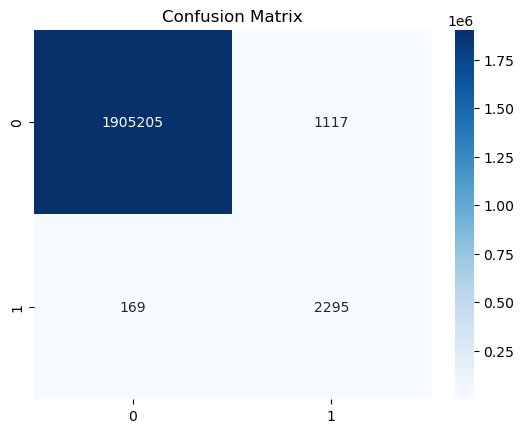

ROC-AUC Score: 0.9982002136036842


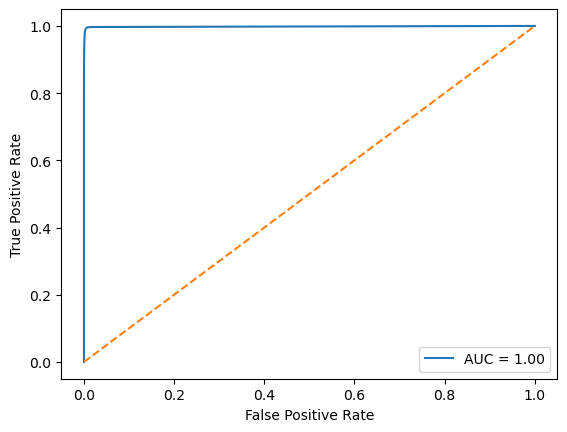

In [8]:
print("Classification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## Step 8 – Feature Importance
We identify which features contribute most to predicting fraud.

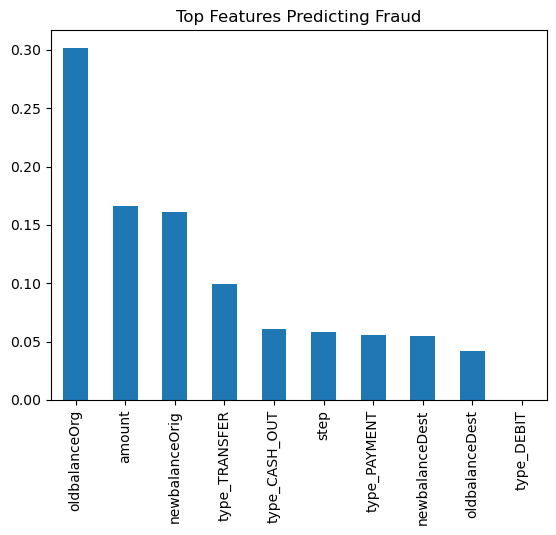

Top 10 Predictive Features:
 oldbalanceOrg     0.301635
amount            0.166130
newbalanceOrig    0.160937
type_TRANSFER     0.099689
type_CASH_OUT     0.060372
step              0.058557
type_PAYMENT      0.055936
newbalanceDest    0.055115
oldbalanceDest    0.041518
type_DEBIT        0.000111
dtype: float64


In [9]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='bar', title='Top Features Predicting Fraud')
plt.show()

print("Top 10 Predictive Features:\n", importances.sort_values(ascending=False).head(10))


## Step 9 – Business Insights
**Top Indicators of Fraud:**
1. **High Original Balance (oldbalanceOrg – 30.16%)**  
   Fraudsters often target accounts with large balances to maximize profit. When a large balance is followed by a transfer or cash-out, it raises fraud risk.  

2. **Large Transaction Amount (amount – 16.61%)**  
   Abnormally large transactions compared to the account’s history are highly suspicious, especially if they occur suddenly without prior patterns.  

3. **Significant Drop in Balance (newbalanceOrig – 16.09%)**  
   A drastic decrease in balance after a transaction can indicate account draining or unauthorized withdrawals.  

4. **Transfer Transactions (type_TRANSFER – 9.97%)**  
   Transfers are a major fraud channel, especially when sent to newly created or suspicious recipient accounts.  

5. **Cash-Out Transactions (type_CASH_OUT – 6.03%)**  
   Fraudsters typically move stolen funds into cash quickly to avoid detection and reversal.  

6. **Transaction Timing (step – 5.85%)**  
   Certain time periods (e.g., late night, early morning) have higher fraud attempts, possibly to avoid real-time monitoring.  

7. **Payments to Risky Entities (type_PAYMENT – 5.59%)**  
   Payments to unusual merchants or payment categories that deviate from customer history can be a fraud indicator.  

8. **Sudden Increase in Recipient Balance (newbalanceDest – 5.51%)**  
   A sharp rise in the recipient’s balance, especially from zero, can suggest a mule account receiving illicit funds.  

9. **Zero or Low Starting Balance in Recipient Account (oldbalanceDest – 4.15%)**  
   Mule accounts often start with minimal funds before receiving large fraudulent transfers.  

10. **Debit Transactions (type_DEBIT – 0.01%)**  
    Rare in occurrence but can still be linked to certain fraud patterns, such as card-not-present attacks.

## Step 10. Recommendations
1. **Real-Time Fraud Scoring**  
   Integrate the model into transaction processing to flag high-risk transfers and cash-outs instantly based on oldbalanceOrg, amount, and type_TRANSFER/type_CASH_OUT patterns.

2. **High-Value Transaction Monitoring**  
   Set automated alerts and step-up authentication (OTP, biometric) for unusually large amounts or significant balance drops.

3. **Velocity Checks**  
   Detect multiple rapid transactions within short time frames (step feature) and place temporary holds until verified.

4. **Recipient Account Risk Scoring**  
   Monitor accounts with near-zero oldbalanceDest that suddenly receive large funds, especially from multiple sources.

5. **Time-of-Day Rules**  
   Flag transactions happening at historically risky times for additional review.

6. **Merchant Category & Payment Pattern Tracking**  
   Track deviations in type_PAYMENT behavior, especially to new or untrusted merchants.

7. **Two-Step Fund Movement Prevention**  
   Since fraud often involves transfer → cash-out, block or delay high-risk sequences to allow fraud teams to investigate.

8. **Continuous Model Retraining**  
   Retrain the model monthly or quarterly using the latest fraud patterns to prevent performance decay.